In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import pandas as pd

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp, BigGenerator, MeanFieldVariationalDistribution, GaussianProcess
from Tools import AverageNormalLogLikelihood, logmvn01pdf
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI_noise import IVI

from tqdm import trange

import timeit

In [3]:
## Hyperparameters ##

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5

#optimizer
learning_rate=0.005

#scheduler
patience=30
lr_decay=.7#.7
min_lr= 0.0001
n_epochs=2000#5000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour

batch_size=50

sigma_prior=.5# TO DO check with other experiments setup.sigma_prior    


input_sampling='uniform' #'uniform', 'uniform+data'


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [33]:
input_sampling='uniform' #'uniform', 'uniform+data'

def OOD_sampler(x_train,n_ood):
    M = x_train.max(0, keepdim=True)[0]
    m = x_train.min(0, keepdim=True)[0]
    X = torch.rand(n_ood,x_train.shape[1]).to(device) * (M-m) + m                           
    return X



def FuNNeVI(dataset,device):

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 

    x_train, y_train=setup.train_data()
    x_test, y_test=setup.test_data()

    std_y_train = torch.tensor(1.)
    if hasattr(setup, '_scaler_y'):
        std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    size_data=len(train_dataset)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    ## predictive model
    input_dim=x_train.shape[1]
    param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)
    
    def prior(n):
        return sigma_prior*torch.randn(size=(n,param_count), device=device)
    

    if input_sampling=='mixture':
        def input_sampler(x_data):
            n_ood=1
            M = x_train.max(0, keepdim=True)[0]
            m = x_train.min(0, keepdim=True)[0]
            X_rand = torch.rand(n_ood,input_dim).to(device) * (M-m) + m                            
            X=torch.cat([x_data,\
                         x_data+0.1*torch.randn_like(x_data),\
                         x_data+0.1*torch.randn_like(x_data),\
                         x_data+0.1*torch.randn_like(x_data),
                         X_rand])   
            return X
    
    if input_sampling=='uniform':
        def input_sampler(x_data):
            n_ood=200
            M = x_train.max(0, keepdim=True)[0]
            m = x_train.min(0, keepdim=True)[0]
            X = torch.rand(n_ood,input_dim).to(device) * (M-m) + m                           
            return X
    
    if input_sampling=='uniform+data':
        def input_sampler(x_data,n_ood=150):
            M = x_train.max(0, keepdim=True)[0]
            m = x_train.min(0, keepdim=True)[0]
            X_rand = torch.rand(n_ood,input_dim).to(device) * (M-m) + m                           
            return torch.cat([x_data,X_rand])
    
    def projection(theta0,theta1, x_data):
        X=input_sampler(x_data)
        #compute projection on both paramters with model
        theta0_proj=model(X, theta0).squeeze(2)
        theta1_proj=model(X, theta1).squeeze(2)
        return theta0_proj, theta1_proj

    def kl(x_data, GeN):

        theta=GeN(n_samples_KL) #variationnel
        theta_prior=prior(n_samples_KL) #prior

        theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

        K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
        return K
    
    
    
    def ELBO(x_data, y_data, GeN, _sigma_noise):
        y_pred=model(x_data,GeN(n_samples_LL))
        sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

        Average_LogLikelihood=AverageNormalLogLikelihood(y_pred, y_data, sigma_noise)
        the_KL=kl(x_data, GeN)
        the_ELBO= - Average_LogLikelihood+ (len(x_data)/size_data)* the_KL
        return the_ELBO, the_KL, Average_LogLikelihood, sigma_noise

    #generative model
    GeN = BigGenerator(lat_dim,param_count,device).to(device)

    ## Parametrize noise for learning aleatoric uncertainty
    
    _sigma_noise=torch.log(torch.tensor(setup.sigma_noise).exp()-1.).clone().to(device).detach().requires_grad_(False)
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

    optimizer = torch.optim.Adam(list(GeN.parameters()), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, min_lr=min_lr)

    Run=IVI(train_loader, ELBO, optimizer)
    
    start = timeit.default_timer()
    with trange(n_epochs) as tr:
        tr.set_description(desc=dataset+'/FuNNeVI', refresh=False)
        for t in tr:
            
            
            scores=Run.run(GeN,_sigma_noise)

            scheduler.step(scores['ELBO'])
            tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'], sigma=scores['sigma'])

            if scores['lr'] <= 1e-4:
                break
    stop = timeit.default_timer()
    time = stop - start
    
    
    
    theta=GeN(1000).detach()
    return theta


def GeNNeVI(dataset,device):

    setup_ = get_setup(dataset)
    setup=setup_.Setup(device) 

    x_train, y_train=setup.train_data()
    x_test, y_test=setup.test_data()

    std_y_train = torch.tensor(1.)
    if hasattr(setup, '_scaler_y'):
        std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()
    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    size_data=len(train_dataset)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  

    ## predictive model
    input_dim=x_train.shape[1]
    param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)
    
    def prior(n):
        return sigma_prior*torch.randn(size=(n,param_count), device=device)
    
    def kl(x_data, GeN):

        theta=GeN(n_samples_KL) #variationnel
        theta_prior=prior(n_samples_KL) #prior

        K=KL(theta, theta_prior,k=kNNE,device=device)
        return K
    
    def ELBO(x_data, y_data, GeN, _sigma_noise):
        y_pred=model(x_data,GeN(n_samples_LL))
        sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

        Average_LogLikelihood=AverageNormalLogLikelihood(y_pred, y_data, sigma_noise)
        the_KL=kl(x_data, GeN)
        the_ELBO= - Average_LogLikelihood+ (len(x_data)/size_data)* the_KL#(len(x_data)/size_data)*the_KL
        return the_ELBO, the_KL, Average_LogLikelihood, sigma_noise

    #generative model
    GeN = BigGenerator(lat_dim,param_count,device).to(device)

    ## Parametrize noise for learning aleatoric uncertainty
    
    _sigma_noise=torch.log(torch.tensor(setup.sigma_noise).exp()-1.).clone().to(device).detach().requires_grad_(False)
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

    optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, min_lr=min_lr)

    Run=IVI(train_loader, ELBO, optimizer)
    
    start = timeit.default_timer()
    with trange(n_epochs) as tr:
        tr.set_description(desc=dataset+'/GeNNeVI', refresh=False)
        for t in tr:
            
            scores=Run.run(GeN,_sigma_noise)

            scheduler.step(scores['ELBO'])
            tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'], sigma=scores['sigma'])

            if scores['lr'] <= 1e-4:
                break
    stop = timeit.default_timer()
    time = stop - start
    
    theta=GeN(1000).detach()
    return theta

In [5]:
dataset='boston'
setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()


def ood_input(x_train,n_ood=50):
    M = x_train.max(0, keepdim=True)[0]
    m = x_train.min(0, keepdim=True)[0]
    X_rand = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
    return X_rand 

def noisy_train(n_ood=50):
    return x_train[:n_ood]+0.1*torch.randn_like(x_train[:n_ood])

input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

In [7]:

theta_Fun=FuNNeVI(dataset,device)


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'FuNNeVI' is not defined

In [36]:
theta_Gen=GeNNeVI(dataset,device)


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
boston/GeNNeVI:  50%|█████     | 1001/2000 [00:56<00:56, 17.70it/s, ELBO=101, KL=91.4, LogLike=-91.4, lr=0.0001, sigma=2.5]  


In [8]:
setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

In [45]:
models_HMC = torch.load('Results/HMC_models.pt')
theta_HMC=models_HMC[dataset][:1000,:].to(device)
pred_HMC = model(x_test,theta_HMC)
sigma_noise=torch.tensor(setup.sigma_noise)
std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()
    
#metrics_HMC=get_metrics(pred_HMC, sigma_noise, y_test, std_y_train, 'HMC', 0.)
#metrics_HMC

/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RuntimeError: Expected object of device type cuda but got device type cpu for argument #0 'result' in call to _th_bmm_out

In [8]:
import seaborn as sns
from pylab import *
from Tools import log_norm



x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()
data='test'
if data=='test':
    x=x_test
if data=='OOD':
    x=ood_input(30)
    #x_train+0.05*torch.rand_like(x_train)##
y_pred_FuN=model(x, theta_Fun.detach())
y_pred_GeN=model(x, theta_Gen.detach())


def prior(n):
    return 0.5*torch.randn(size=(n,param_count), device=device)

pred_prior=model(x, prior(1000))
sigma_noise=torch.tensor(setup.sigma_noise)
pred_GeN=y_pred_GeN+sigma_noise*torch.randn_like(y_pred_GeN)
pred_FuN=y_pred_FuN+sigma_noise*torch.randn_like(y_pred_FuN)

models_HMC = torch.load('Results/HMC_models.pt')
theta_HMC=models_HMC[dataset][:1000,:].to(device)
pred_HMC = model(x,theta_HMC)
pred_HMC+=setup.sigma_noise*torch.randn_like(pred_HMC)



sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
N=10
M=3
#np.random.seed(42)

for _ in range(1,1+N*M):
    i=np.random.randint(0,x.shape[0])
    subplot(N,M,_)
    #line4=plt.axvline(pred_FuN.mean(0)[i].cpu(), color='blue', lw=2.,label='mean FuN')
#    line4=plt.axvline(pred_GeN.mean(0)[i].cpu(), color='orange', lw=2.,label='mean GeN')

    ax =sns.distplot(pred_FuN[:,i].cpu(),label='FuN', color='blue')
    line5 =ax=sns.distplot(pred_GeN[:,i].cpu(),label='GeN', color='red')
#    line5 =sns.distplot(pred_prior[:,i].cpu(),label='prior', color='green')
    ax=sns.distplot(pred_HMC[:,i].cpu(),label='HMC', color='gold')


    line1=plt.axvline(y_test[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
# plt.suptitle(t='Posterior Predictive on {} (HMC, RMSE: {:3f}, LPP:{:3f}), (GeNNeVI, RMSE: {:3f}, LPP:{:3f}) ,(FuNNeVI, RMSE: {:3f}, LPP:{:3f})'\
#              .format(data, metrics_HMC[('HMC', 'RMSE')],metrics_HMC[('HMC', 'LPP')],\
#                      metrics_GeN[('GeNNeVI', 'RMSE')],metrics_GeN[('GeNNeVI', 'LPP')],\
#                      metrics_FuN[('FuNNeVI', 'RMSE')],metrics_FuN[('FuNNeVI', 'LPP')]))


NameError: name 'theta_Fun' is not defined

In [9]:
def BatchEntropy_(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)
#from Metrics import BatchEntropy

def EntropyScatterPlot(theta):
    X=[x_train,x_test,OOD_sampler(x_train,1000)]
    Y=[model(X[i],theta) for i in range(len(X))]
    H=[]
    for i in range(len(Y)):
        H.append(BatchEntropy(Y[i].transpose(0,1),k=len(Y[i])//100))
    return H


def EntropyScatterPlot(ax,theta,X, label, k,title):
    Y=[model(X[i],theta) for i in range(len(X))]
    for i in range(len(Y)):
        H=BatchEntropy(Y[i].transpose(0,1),k=k)
        sns.distplot(H.cpu(), label=label[i], ax=ax)
    ax.set_title(title)



x=x_test
x_ood=ood_input(x_train,1000).to(device)
x_train_noisy=x_train+0.1*torch.rand_like(x_train)##
y_pred_FuN=model(x, theta_Fun.detach().to(device))
#y_pred_GeN=model(x, GeN_GeN(1000).detach())
X=[x_train,x_test,x_train_noisy,x_ood]
label=['train','test','noisy train', 'OOD']
theta_HMC=models_HMC[dataset][1000:2000,:].to(device)

def prior(n):
    return 0.5*torch.randn(size=(n,param_count), device=device)

fig,ax=plt.subplots(4,1,figsize=(10,10))

#theta_Fun=GeN_FuN(1000).detach()
EntropyScatterPlot(ax[0],prior(1000),X,label,100,'prior')

EntropyScatterPlot(ax[1],theta_HMC.to(device),X,label,30,'HMC')
EntropyScatterPlot(ax[2],theta_Gen.to(device),X,label,30,'GeNNeVI')
EntropyScatterPlot(ax[3],theta_Fun.to(device),X,label,30,'FuNNeVI')
#theta_GeN=GeN_GeN(1000).detach()

plt.legend()

fig.tight_layout()


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'theta_Fun' is not defined

torch.Size([455])
torch.Size([51])
torch.Size([1000])
torch.Size([455])
torch.Size([51])
torch.Size([1000])
torch.Size([455])
torch.Size([51])
torch.Size([1000])
[torch.Size([455]), torch.Size([51]), torch.Size([1000])]


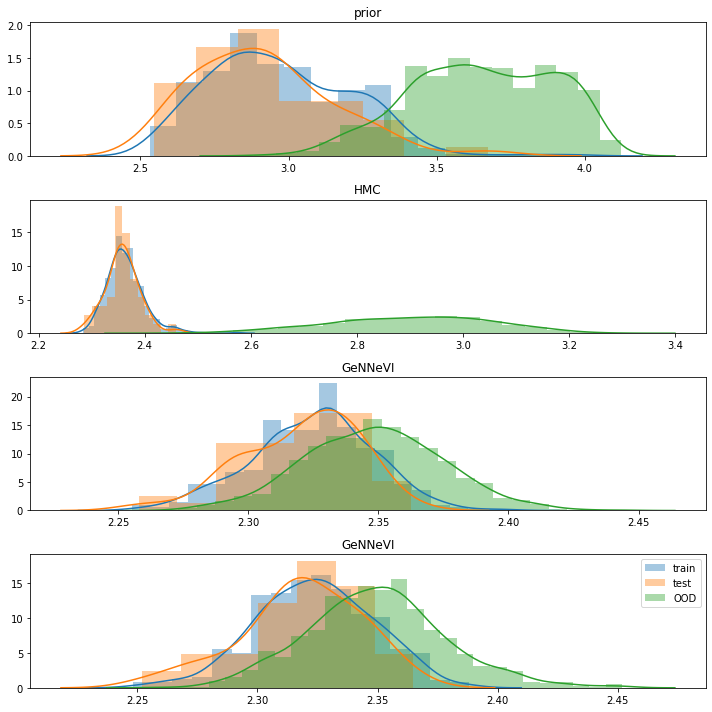

In [17]:
from Metrics import BatchEntropy
def BatchEntropy_(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)
#from Metrics import BatchEntropy


def EntropyScatterPlot(ax,theta,X, label, k,title):
    Y_=[model(X[i],theta) for i in range(len(X))]
    Y=[y+setup.sigma_noise*torch.randn_like(y) for y in Y_]
    H=[BatchEntropy(y.transpose(0,1),k=30) for y in Y]
    for i in range(len(Y)):
        H=BatchEntropy_(Y[i].transpose(0,1),k=k)
        print(H.shape)
        sns.distplot(H.cpu(), label=label[i], ax=ax)
    ax.set_title(title)



x=x_test
x_ood=ood_input(x_train,1000).to(device)
x_train_noisy=x_train+0.1*torch.rand_like(x_train)##
#y_pred_GeN=model(x, GeN_GeN(1000).detach())
X=[x_train,x_test,x_ood]
label=['train','test','OOD']
#theta_HMC=models_HMC[dataset][1000:2000,:].to(device)

def prior(n):
    return 0.5*torch.randn(size=(n,param_count), device=device)

fig,ax=plt.subplots(4,1,figsize=(10,10))

#theta_Fun=GeN_FuN(1000).detach()
EntropyScatterPlot(ax[0],prior(1000),X,label,100,'prior')

Entropy=torch.load('Results/NEW/UCI_ENTROPY_Fixed_Noise2020-10-13-17:20.pt')
H=Entropy['boston']['HMC'][1]

#for i in range(len(H)):
EntropyScatterPlot(ax[1],H,X,label,30,'HMC')

H=Entropy['boston']['GeNNeVI'][1]

EntropyScatterPlot(ax[2],H,X,label,30,'GeNNeVI')

H=Entropy['boston']['GeNNeVI'][0]
for i in range(len(H)):
    sns.distplot(H[i].cpu(), label=label[i], ax=ax[3])
    ax[3].set_title('GeNNeVI')

#EntropyScatterPlot(ax[2],theta_Gen.to(device),X,label,30,'GeNNeVI')
#EntropyScatterPlot(ax[3],theta_Fun.to(device),X,label,30,'FuNNeVI')
#theta_GeN=GeN_GeN(1000).detach()
print([h.shape for h in H])
plt.legend()

fig.tight_layout()


In [4]:
cd ..

/home/yann/IVISpaces


455 51 1000


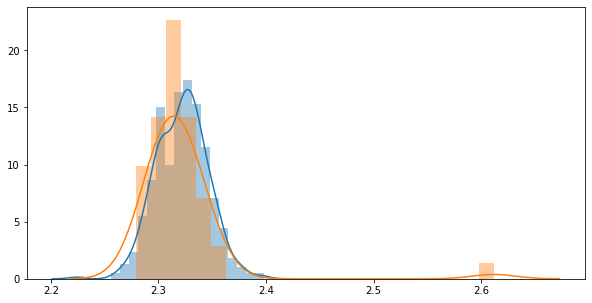

In [12]:
import torch
from pylab import *
import seaborn as sns
Entropy=torch.load('Results/NEW/UCI_ENTROPY_Fixed_Noise2020-10-12-22:33.pt')
H=Entropy['boston']['FuNNeVI']
label=['train','test','noisy train', 'OOD']
print(len(H[0]),len(H[1]), len(H[2]))


fig,ax=plt.subplots(figsize=(10,5))
def EntropyScatterPlot(ax, H, label):
    for i in range(2):
        sns.distplot(H[i].cpu(), label=label[i], ax=ax)
EntropyScatterPlot(ax,H, label)

In [21]:
def FunKL(s, t, model, sampler, n=500):
    assert t.shape == s.shape
    KLs = torch.Tensor(n)
    for i in range(n):
        rand_input=sampler()
        t_=model(rand_input,t).squeeze(2)
        s_=model(rand_input,s).squeeze(2)
        k=1
        K= KL(t_, s_, k=k, device=device)     
        while torch.isinf(K):
            k+=1
            K= KL(t_, s_, k=k, device=device)
        KLs[i]=K
    return K.mean()  # , K.std()
def CompareWithHMC(thetas, dataset, method):
    divergences={}
    divergences_std={}
    setup_ = get_setup(dataset)
    setup=setup_.Setup(thetas[0].device) 

    x_train, y_train=setup.train_data()
    sampler= lambda :OOD_sampler(x_train=x_train,n_ood=50)
    ## predictive model
    input_dim=x_train.shape[1]
    param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)
    
    HMC_=models_HMC[dataset]
    indices = torch.randperm(len(HMC_))[:1000]
    HMC=HMC_[indices].to(thetas[0].device)#models_HMC[dataset][:thetas[0].shape[0],:].to(device)        

    
    metric='KL(-,HMC)'
    print(dataset+': '+metric)
    KLs=[]
    for theta in thetas:
        K=FunKL(theta,HMC,model,sampler)
        print(K.item())
        KLs.append(K.item())
    
    divergences.update({metric:np.mean(KLs)})
    divergences_std.update({metric:np.std(KLs)})
    
    metric='KL(HMC,-)'
    print(dataset+': '+metric)
    KLs=[]
    for theta in thetas:
        K=FunKL(HMC,theta,model,sampler)
        print(K.item())
        KLs.append(K.item())
    
    divergences.update({metric:np.mean(KLs)})
    divergences_std.update({metric:np.std(KLs)})
    
#     metric='KL(-,-)'
#     print(dataset+': '+metric)
#     KLs=[]
        
#     models_pairs=list(itertools.combinations(thetas,2))
#     KLs=[]
#     for theta_0,theta_1 in models_pairs:
#         K=FunKL(theta_0,theta_1,model,sampler)
#         print(K.item())
#         KLs.append(K.item())    
   
#     divergences.update({metric:np.mean(KLs)})
#     divergences_std.update({metric:np.std(KLs)})
    
    metrics=list(divergences.keys())
    for j in metrics:
        divergences[(method,j)] = divergences.pop(j)
        divergences_std[(method,j)] = divergences_std.pop(j)
    return divergences, divergences_std

In [22]:
div, Sdiv= CompareWithHMC([theta_Gen], dataset,'GeNNeVI')
div

boston: KL(-,HMC)
9.702526092529297
boston: KL(HMC,-)
62.969703674316406


{('GeNNeVI', 'KL(-,HMC)'): 9.702526092529297,
 ('GeNNeVI', 'KL(HMC,-)'): 62.969703674316406}

In [23]:
div, Sdiv= CompareWithHMC([theta_Fun], dataset,'FuNNeVI')
div

boston: KL(-,HMC)
62.81312561035156
boston: KL(HMC,-)
2.0310864448547363


{('FuNNeVI', 'KL(-,HMC)'): 62.81312561035156,
 ('FuNNeVI', 'KL(HMC,-)'): 2.0310864448547363}